Uses backpropagation through time. feeds and predicts pointwise as propagating through time steps. Input[batch, seq, 1]


with A trainable


In [2]:
import numpy as np
import pandas as pd
from scipy.linalg import expm

from scipy.io import loadmat
import matplotlib.pyplot as plt


from tqdm import tqdm

In [3]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf

# from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn

import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



2024-11-26 20:33:52.551922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 20:33:53.640669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
#training/testing data 

num_time_steps=20

time_steps=torch.linspace(0,10,num_time_steps)

sin_wave=torch.sin(time_steps).reshape(-1, 1)


sequence_length=1

sequence_data = []
for i in range(num_time_steps - sequence_length):
    sequence_data.append(sin_wave[i: i + sequence_length+1, 0])


sequence_data=torch.stack(sequence_data)

num_train_samples=int(sequence_data.shape[0]*.8)



train_set = sequence_data[:num_train_samples, :]
test_set = sequence_data[num_train_samples:, :]



In [5]:
    # Take off the last element of each row and this will be our target value to predict.
x_train = train_set[np.newaxis,:, :-1].to(device)#[batch,seq_len,1]
y_train = train_set[:, -1][:, np.newaxis].to(device)#[:, np.newaxis]
x_test = test_set[:, :-1]#[:, :, np.newaxis]
y_test = test_set[:, -1].to(device)#[:, np.newaxis]

x_train.shape

torch.Size([1, 15, 1])

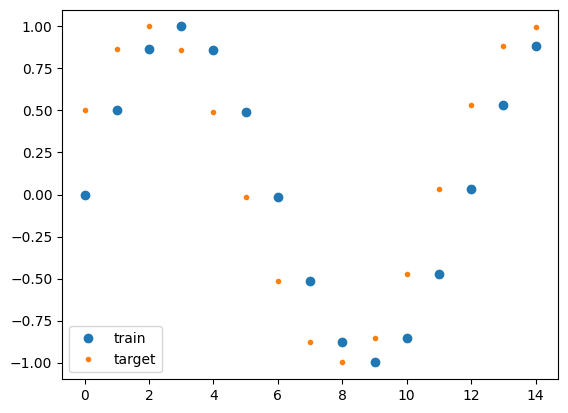

In [6]:
plt.plot(x_train[0,:,0].cpu().numpy(),'o',label='train')
plt.plot(y_train.cpu().numpy(),'.',label='target')
plt.legend()

In [7]:
#parameters for the recurrent layer

dt = 0.001
T = 4
t=np.arange(0,T,dt)
N = 100                          #number of nodes in the cv-NN
epsilon = 50

phi = 1.5513                     #delay parameter
alpha = 1.0                      #power-law for the connectivity
f_mu = 5                          #(Hz) natural frequency
omega = (f_mu*np.ones((N,1)))*2*np.pi   #natural frequency

num=x_train.shape[0] # number of training samples 


def distance_dependent_graph(N, alpha):
    """
    Generates a distance-dependent graph based on a power-law for connectivity.

    Parameters:
    N (int): Number of nodes.
    alpha (float): Power-law exponent.

    Returns:
    numpy.ndarray: The adjacency matrix (weighted) representing the network.
    """
    # Initialize the adjacency matrix (A) and distance matrix (d)
    A = np.zeros((N, N))
    d = np.full((N, N), np.nan)

    # Calculate the distance between each pair of nodes considering periodic boundaries
    for ii in range(N):
        for jj in range(N):
            if ii == jj:
                continue  # Skip self-loops
            dist = abs(ii - jj)
            d[ii, jj] = min(dist, N - dist)  # Use periodic boundary conditions

    # Calculate the normalization factor eta
    eta = np.nansum(1.0 / d[0, :] ** alpha)

    # Calculate the adjacency matrix A using the power-law
    A = (1.0 / eta) * (1.0 / d ** alpha)

    # Ensure diagonal elements are zero (no self-loops)
    np.fill_diagonal(A, 0)

    return A


In [8]:
# eps_in = 0.1
# w_in = eps_in * np.random.rand(N, 1)
    
# Adjacency matrix (recurrent layer)
a = distance_dependent_graph(N, alpha)

K = epsilon * np.exp(-1j * phi) * a

# Initial condition
np.random.seed(100)
x_0 = np.random.rand(N) * np.exp(1j * 2 * np.pi * (np.random.rand(N) - 0.5))
 
#split the initial condition into real and imag part and convert it to torch tensor(not param as non trainable)

x_0_r=torch.tensor(x_0.real, dtype=torch.float32, requires_grad=False).to(device)

x_0_imag=torch.tensor(x_0.imag, dtype=torch.float32, requires_grad=False).to(device)

In [10]:
#returns the real and imag part of the state after propagating them for a given t


class cv_NN_state(nn.Module):
    def __init__(self, num, N, t, omega, dt, K, x_0_r, x_0_imag, device):
        super(cv_NN_state, self).__init__()
        
        
        # Store parameters
        self.num = num
        self.N = N
        self.t = t
        self.device = device
        
        # Initialize real and imaginary parts of `x_th`
        self.x_th_r = torch.zeros((num, len(t), N), dtype=torch.float32, requires_grad=False).to(device) #batch,len(t),N
        self.x_th_imag = torch.zeros((num, len(t), N), dtype=torch.float32, requires_grad=False).to(device)

        self.A = nn.Parameter(torch.tensor(a))#.to(device)
        
        self.K = epsilon * np.exp(-1j * phi) * a
        
        # Compute `propagate` and split into real and imaginary parts
        propagate = np.exp(1j * omega * dt) * expm(dt * self.K)
        
        self.propagate_r = nn.Parameter(torch.tensor(propagate.real, dtype=torch.float32, requires_grad=False)).to(device)
        self.propagate_imag = nn.Parameter(torch.tensor(propagate.imag, dtype=torch.float32, requires_grad=False)).to(device)

        
        
        # Initialize the first state
        self.x_th_r[:, 0, :] = x_0_r
        self.x_th_imag[:, 0, :] = x_0_imag
        
        
        
        
    def forward(self):
        
    # Expand propagate_r and propagate_imag to batch process with `torch.matmul`
        propagate_r_expanded = self.propagate_r.unsqueeze(0).expand(self.num, -1, -1)  # (num, N, N)
        propagate_imag_expanded = self.propagate_imag.unsqueeze(0).expand(self.num, -1, -1)  # (num, N, N)
        
        
        # Initialize tensors for outputs and intermediate states
        x_th_r = [self.x_th_r[:, 0, :]]
        x_th_imag = [self.x_th_imag[:, 0, :]]
        

        # Iterate over time steps, starting from the second time step
        for j in range(1, len(self.t)):
            
            
  
                
            # Prepare inputs for batch matrix multiplication
            previous_r = x_th_r[-1].unsqueeze(-1)  # (num, N, 1)
            previous_imag = x_th_imag[-1].unsqueeze(-1)  # (num, N, 1)

            # print(torch.matmul(propagate_r_expanded, previous_r).shape)

            # Compute real and imaginary parts in parallel
            real_part = torch.matmul(propagate_r_expanded, previous_r).squeeze(-1) \
                    - torch.matmul(propagate_imag_expanded, previous_imag).squeeze(-1) \
                    

            imag_part = torch.matmul(propagate_r_expanded, previous_imag).squeeze(-1) \
                    + torch.matmul(propagate_imag_expanded, previous_r).squeeze(-1)
            
            
            # Append the computed real and imaginary parts to lists
            x_th_r.append(real_part)
            x_th_imag.append(imag_part)



            
        # Stack intermediate states and outputs
        x_th_r = torch.stack(x_th_r, dim=1)  # (num, len(t), N)
        x_th_imag = torch.stack(x_th_imag, dim=1)  # (num, len(t), N)
            

        return x_th_r.to(self.device),x_th_imag.to(self.device)
               

In [11]:
cvNNstate=cv_NN_state(num=num, N=N, t=t, omega=omega, dt=dt, K=K, x_0_r=x_0_r, x_0_imag=x_0_imag, device=device)

xr,xi=cvNNstate()

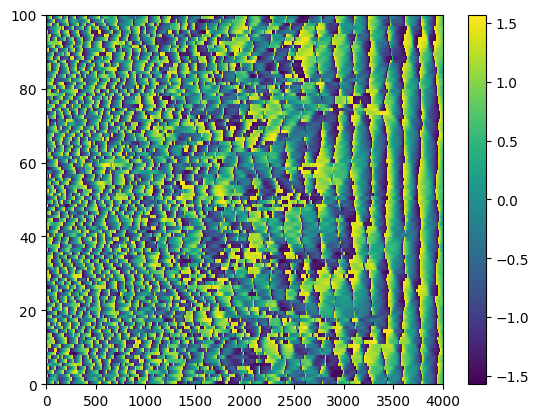

In [12]:
p=torch.arctan(xi/xr)

plt.pcolor(p[0,:,:].detach().cpu().numpy().T)
plt.colorbar()

In [19]:
class cv_NN_readout(nn.Module):
    def __init__(self, num, N, t, omega, dt, K, x_0_r, x_0_imag, device):
        super(cv_NN_readout, self).__init__()
        
        
        # Store parameters
        self.num = num
        self.N = N
        # self.t = t
        self.device = device
        
        # self.inputD=inputD
        
        # Initialize real and imaginary parts of `x_th`
        # self.x_th_r = torch.zeros((num, inputD.shape[1], N), dtype=torch.float32, requires_grad=False).to(device) #batch,len(t),N
        # self.x_th_imag = torch.zeros((num, inputD.shape[1], N), dtype=torch.float32, requires_grad=False).to(device)

        self.A = nn.Parameter(torch.tensor(a))#.to(device)
        
        self.K = epsilon * np.exp(-1j * phi) * a
        
        # Compute `propagate` and split into real and imaginary parts
        propagate = np.exp(1j * omega * dt) * expm(dt * self.K)
        self.propagate_r = nn.Parameter(torch.tensor(propagate.real, dtype=torch.float32, requires_grad=True)).to(device)
        self.propagate_imag = nn.Parameter(torch.tensor(propagate.imag, dtype=torch.float32, requires_grad=True)).to(device)

        # self.propagate_r = nn.Parameter(torch.tensor(propagate.real, dtype=torch.float32)).to(device)
        # self.propagate_imag = nn.Parameter(torch.tensor(propagate.imag, dtype=torch.float32)).to(device)
        # Trainable parameter `W2`
        self.W1 = nn.Parameter(torch.randn(N), requires_grad=True).to(device)
        
        
        # Initialize the first state
        self.x_0_r = x_0_r
        self.x_0_imag = x_0_imag
        
        
        
        
        
        self.real_weight = nn.Parameter(torch.randn(1, self.N,device=device) ,requires_grad=True)
        self.imag_weight = nn.Parameter(torch.randn(1, self.N,device=device) ,requires_grad=True)
        
        
        
        
    def forward(self,inputD):
        
    # Expand propagate_r and propagate_imag to batch process with `torch.matmul`
        propagate_r_expanded = self.propagate_r.unsqueeze(0).expand(self.num, -1, -1)  # (num, N, N)
        propagate_imag_expanded = self.propagate_imag.unsqueeze(0).expand(self.num, -1, -1)  # (num, N, N)
        
        
        # Initialize tensors for outputs and intermediate states
        x_th_r = [self.x_0_r]
        x_th_imag = [self.x_0_imag]
        
        output_i=[]
        
        output_r=[]

        # Iterate over time steps, starting from the second time step
        for j in range(0, inputD.shape[1]):
            
            
  
                
            # Prepare inputs for batch matrix multiplication
            previous_r = x_th_r[-1].unsqueeze(-1)  # (num, N, 1)
            previous_imag = x_th_imag[-1].unsqueeze(-1)  # (num, N, 1)

            # print(torch.matmul(propagate_r_expanded, previous_r).shape)

            # Compute real and imaginary parts in parallel
            real_part = torch.matmul(propagate_r_expanded, previous_r).squeeze(-1) \
                    - torch.matmul(propagate_imag_expanded, previous_imag).squeeze(-1) \
                    + self.W1 * inputD[:, j,:].to(device)

            imag_part = torch.matmul(propagate_r_expanded, previous_imag).squeeze(-1) \
                    + torch.matmul(propagate_imag_expanded, previous_r).squeeze(-1)
            
            
            # Append the computed real and imaginary parts to lists
            x_th_r.append(real_part)
            x_th_imag.append(imag_part)

            # # Update x_th_r and x_th_imag at the current time step
            # self.x_th_r[:, j, :] = real_part
            # self.x_th_imag[:, j, :] = imag_part


            real_output = torch.matmul(real_part, self.real_weight.T) - torch.matmul(imag_part, self.imag_weight.T)

            # Compute imaginary part of the output
            imag_output = torch.matmul(real_part, self.imag_weight.T) + torch.matmul(imag_part, self.real_weight.T)

            output_r.append(real_output)
            output_i.append(imag_output)
            
        # Stack intermediate states and outputs
        x_th_r = torch.stack(x_th_r, dim=1)  # (num, len(t), N)
        x_th_imag = torch.stack(x_th_imag, dim=1)  # (num, len(t), N)
            

        return torch.stack(output_r,dim=1).to(self.device),torch.stack(output_i,dim=1).to(self.device)
               

In [20]:
# Initialize network, optimizer, and criterion
# net = ComplexNet(in_features=N, out_features=1)

net=cv_NN_readout(num=num, N=N, t=t, omega=omega, dt=dt, K=K, x_0_r=xr[:,-1,:], x_0_imag=xi[:,-1,:], device=device)
# torch.autograd.set_detect_anomaly(True)
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [21]:
# Count the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Display the number of trainable parameters
print(f"Number of trainable parameters: {count_parameters(net)}")

Number of trainable parameters: 10200


In [31]:

# D=torch.tensor(y[0:num,:]).to(device)
num_epoch=1000
# Training loop
for epoch in range(num_epoch):
    optimizer.zero_grad()
    
    # Forward pass
    real_output, imag_output = net(x_train)

    
    # Calculate loss
    loss_real = criterion(real_output[0,:,:], y_train)
    loss_imag = criterion(imag_output,torch.zeros(imag_output.shape).to(device))
    loss = loss_real + loss_imag
    
    # Backward pass and optimize
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 0.0045
Epoch [101/1000], Loss: 0.0042
Epoch [201/1000], Loss: 0.0042
Epoch [301/1000], Loss: 0.0038
Epoch [401/1000], Loss: 0.0269
Epoch [501/1000], Loss: 0.0036
Epoch [601/1000], Loss: 0.0035
Epoch [701/1000], Loss: 0.0063
Epoch [801/1000], Loss: 0.0034
Epoch [901/1000], Loss: 0.0033


In [42]:
# input_test=torch.randn(80,4000,device=device)#torch.randn(80,4000,device=device)
# input_data[0,-num_train_samples:,:].shape

In [32]:
r_1, i_1 = net(x_train)
# np.max(r_1)

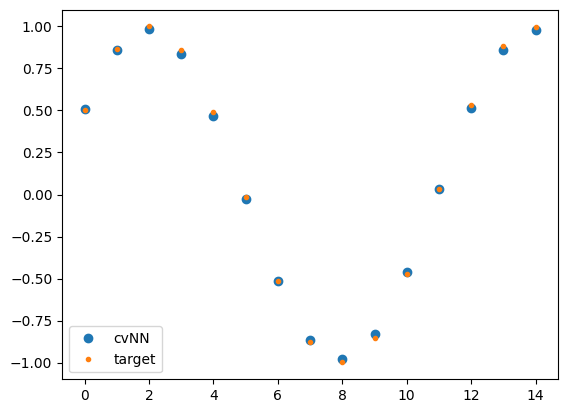

In [36]:
plt.plot(r_1[0,:,:].cpu().detach().numpy(),'o',label="cvNN")
plt.plot(y_train.cpu().detach().numpy(),'.',label="target")
plt.legend()

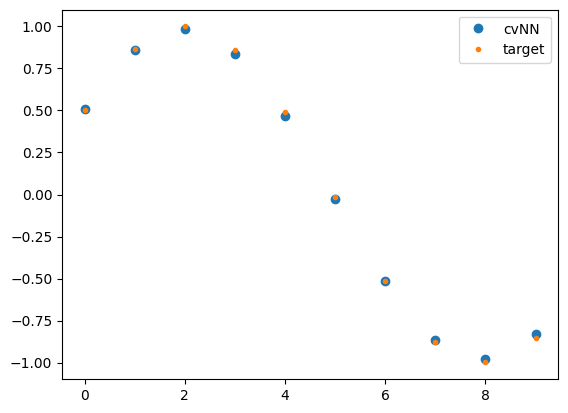

In [49]:
r_2, i_2 = net(x_train[:,:10,:])

plt.plot(r_2[0,:,:].cpu().detach().numpy(),'o',label="cvNN")
plt.plot(y_train[:10,:].cpu().detach().numpy(),'.',label="target")
plt.legend()

In [ ]:
# in_features = N
# out_features = 10
# layer = ComplexLinear(in_features, out_features)

## Testing